In [5]:
# --- Step 1: Setup ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Make plots look nice
plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)




In [6]:

# Step 1: Mount Drive
from google.colab import drive
drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
# Step 2: Load CSV from your Drive
import pandas as pd


path = "/content/drive/MyDrive/btcusd_1-min_data.csv"
df = pd.read_csv(path)

df.head()


,Timestamp,Open,High,Low,Close,Volume
0,1.325412e+09,4.58,4.58,4.58,4.58,0.0
1,1.325412e+09,4.58,4.58,4.58,4.58,0.0
2,1.325412e+09,4.58,4.58,4.58,4.58,0.0
3,1.325412e+09,4.58,4.58,4.58,4.58,0.0
4,1.325412e+09,4.58,4.58,4.58,4.58,0.0


In [9]:
import numpy as np

# Try to find a time-like column
time_candidates = [c for c in df.columns if c.lower() in ("date","datetime","timestamp","time")]
if not time_candidates:
    raise ValueError("Couldn't find a time column. Check df.columns() to identify the timestamp column.")

ts_col = time_candidates[0]

# Convert to pandas datetime
if ts_col.lower() == "timestamp":
    # Decide seconds vs milliseconds by value magnitude
    sample_val = df[ts_col].dropna().iloc[0]
    if sample_val > 10_000_000_000:   # > ~year 2286 in seconds → likely ms
        df["DateTime"] = pd.to_datetime(df[ts_col], unit="ms", errors="coerce")
    else:
        df["DateTime"] = pd.to_datetime(df[ts_col], unit="s", errors="coerce")
else:
    # Let pandas parse (works for ISO strings like 2017-01-01 00:00:00)
    df["DateTime"] = pd.to_datetime(df[ts_col], errors="coerce")

# Drop rows that failed to parse and sort
df = df.dropna(subset=["DateTime"]).sort_values("DateTime")
df.head(3)[["DateTime"]]


,DateTime
0,2012-01-01 10:01:00
1,2012-01-01 10:02:00
2,2012-01-01 10:03:00


In [10]:
# Choose price column
price_candidates = [c for c in df.columns if c.lower() in ("close","weighted_price","price","last")]
if not price_candidates:
    raise ValueError("Couldn't find a price column (e.g., Close or Weighted_Price). Check df.columns().")

price_col = price_candidates[0]

# Set index to time and resample from minute → daily
daily = (df.set_index("DateTime")[price_col]
           .asfreq("T")                 # ensure a uniform minute index (optional, safe)
           .dropna()
           .resample("D")
           .last()
           .to_frame("Close"))

# If your dataset only has Weighted_Price, rename for consistency
daily.rename(columns={price_col: "Close"}, inplace=True, errors="ignore")

# Compute daily returns (%)
daily["Return"] = daily["Close"].pct_change() * 100
daily = daily.dropna()
daily.head()


/tmp/ipython-input-1244590887.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  .asfreq("T")                 # ensure a uniform minute index (optional, safe)


,Close,Return
DateTime,,
2012-01-02,5.00,3.305785
2012-01-03,5.29,5.800000
2012-01-04,5.57,5.293006
2012-01-05,6.42,15.260323
2012-01-06,6.40,-0.311526


In [11]:
import numpy as np

mean_ret   = daily["Return"].mean()
median_ret = daily["Return"].median()
std_ret    = daily["Return"].std()
var_ret    = daily["Return"].var()

print(f"Mean daily return:   {mean_ret:.3f}%")
print(f"Median daily return: {median_ret:.3f}%")
print(f"Std dev (daily):     {std_ret:.3f}%")
print(f"Variance (daily):    {var_ret:.3f}")


Mean daily return:   0.287%
Median daily return: 0.158%
Std dev (daily):     4.094%
Variance (daily):    16.757


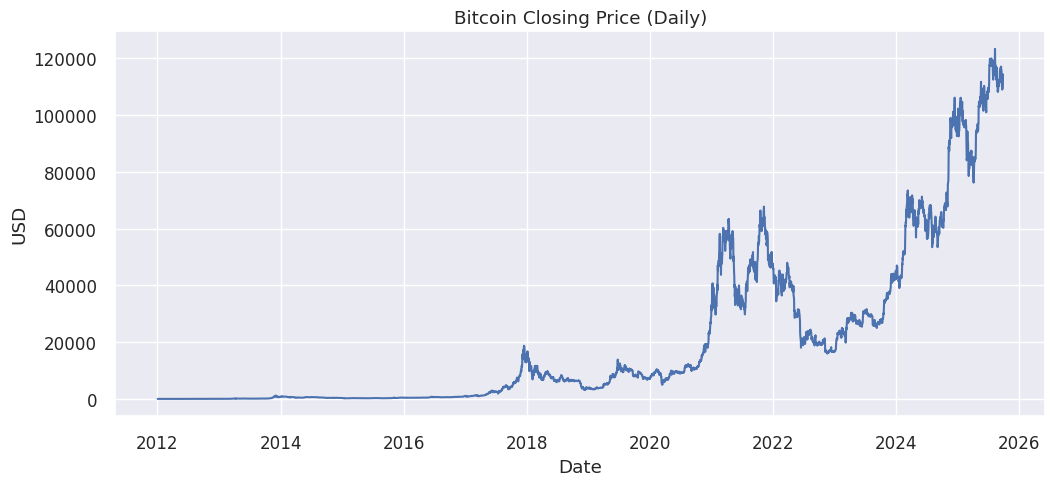

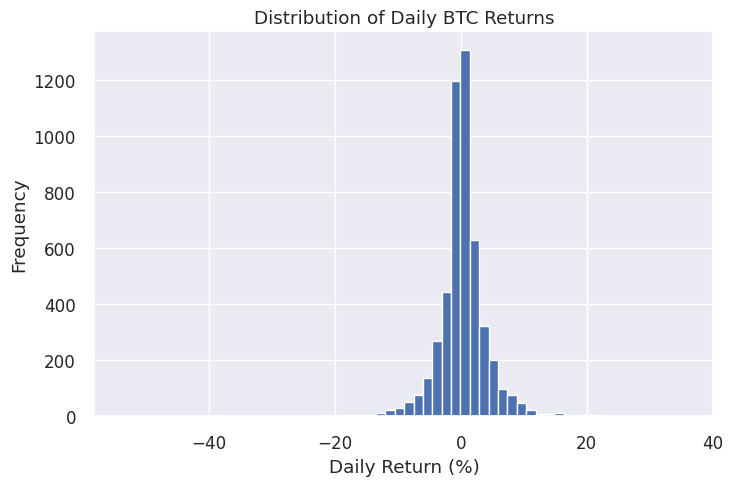

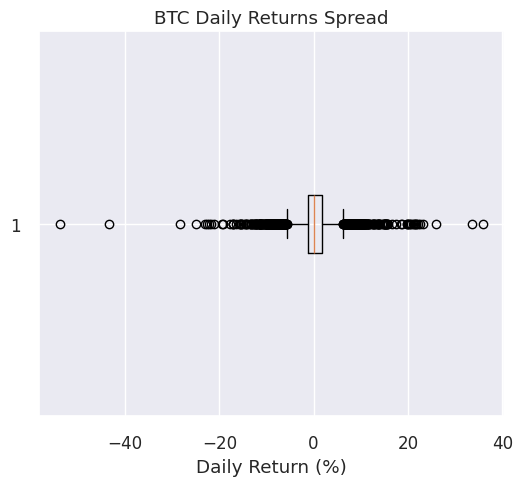

In [12]:
import matplotlib.pyplot as plt

# Price over time
plt.figure(figsize=(12,5))
plt.plot(daily.index, daily["Close"])
plt.title("Bitcoin Closing Price (Daily)")
plt.xlabel("Date"); plt.ylabel("USD")
plt.show()

# Histogram of daily returns
plt.figure(figsize=(8,5))
plt.hist(daily["Return"], bins=60)
plt.title("Distribution of Daily BTC Returns")
plt.xlabel("Daily Return (%)"); plt.ylabel("Frequency")
plt.show()

# Boxplot of daily returns (volatility)
plt.figure(figsize=(6,5))
plt.boxplot(daily["Return"].dropna(), vert=False)
plt.title("BTC Daily Returns Spread")
plt.xlabel("Daily Return (%)")
plt.show()


In [13]:
import os
os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(12,5))
plt.plot(daily.index, daily["Close"])
plt.title("Bitcoin Closing Price (Daily)")
plt.xlabel("Date"); plt.ylabel("USD")
plt.savefig("plots/btc_price_daily.png"); plt.close()

plt.figure(figsize=(8,5))
plt.hist(daily["Return"], bins=60)
plt.title("Distribution of Daily BTC Returns")
plt.xlabel("Daily Return (%)"); plt.ylabel("Frequency")
plt.savefig("plots/btc_returns_hist.png"); plt.close()

plt.figure(figsize=(6,5))
plt.boxplot(daily["Return"].dropna(), vert=False)
plt.title("BTC Daily Returns Spread")
plt.xlabel("Daily Return (%)")
plt.savefig("plots/btc_returns_box.png"); plt.close()
